In [1]:
import pandas as pd
from geopy.distance import geodesic
import requests
from sklearn.cluster import KMeans
from scipy.spatial import distance_matrix
import json
import vincent
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
import re
import seaborn as sns
import numpy as np
import folium
from folium.plugins import HeatMap
from shapely.geometry import Polygon
from pykml import parser
import os
os.environ['SHAPE_RESTORE_SHX'] = 'YES'

In [2]:
fuel_df = pd.read_csv('alt_fuel_stations (Jul 29 2021).csv')
fuel_df.head()

/var/folders/ly/6s9xls1s5k92nhwz4573k3vm0000gp/T/ipykernel_79104/2859254457.py:1: DtypeWarning: Columns (3,6,10,13,14,15,16,20,29,31,33,34,35,36,43,45,46,47,49,52,53,54,56,57,58,59,60,61,62,63) have mixed types. Specify dtype option on import or set low_memory=False.
  fuel_df = pd.read_csv('alt_fuel_stations (Jul 29 2021).csv')


,Fuel Type Cotion Directions,City,State,ZIP,Plus4,Station Phone,Status Code,Expected Date,Groups With Access Code,Access Days Time,...,Hydrogen Standards,CNG Fill Type Code,CNG PSI,CNG Vehicle Class,LNG Vehicle Class,EV On-Site Renewable Source,Restricted Accessde,Station Name,Street Address,Intersec
0,CNG,Spire - Montgomery Operations Center,2951 Chestnut St,NaN,Montgomery,AL,36107,NaN,NaN,E,...,NaN,NaN,NaN,NaN,B,3600,MD,NaN,NaN,NaN
1,CNG,PS Energy - Atlanta,340 Whitehall St,"From I-7585 N, exit 91 to Central Ave, left on...",Atlanta,GA,30303,NaN,770-350-3000,E,...,NaN,NaN,NaN,NaN,Q,3600,MD,NaN,NaN,NaN
2,CNG,Metropolitan Atlanta Rapid Transit Authority,2424 Piedmont Rd NE,NaN,Atlanta,GA,30324,NaN,NaN,E,...,NaN,NaN,NaN,NaN,Q,3000,LD,NaN,NaN,NaN
3,CNG,United Parcel Service,270 Marvin Miller Dr,NaN,Atlanta,GA,30336,NaN,NaN,E,...,NaN,NaN,NaN,NaN,B,3600,HD,NaN,NaN,NaN
4,CNG,Clean Energy - Texas Department of Transportation,7721A Washington St,"I-10, Washington Ave exit, 1.5 blocks to the s...",Houston,TX,77007,NaN,866-809-4869,E,...,NaN,NaN,NaN,NaN,Q,3000 3600,MD,NaN,NaN,NaN


In [3]:
#Cleaning the Data
#Identify the columns to keep from original df
columns_to_keep = ['City', 'ID', 'Updated At', 'Fuel Type Cotion Directions','LPG Primary', 'Plus4', 'State', 'Station Phone']  

# Select only the specified columns
cleaned_df = fuel_df[columns_to_keep]
    
# Print the DataFrame with selected columns
cleaned_df.sample(15)
type(cleaned_df['City'])
type(cleaned_df['Updated At'])

# I need to remake new columns to make the DF easier to understand
cleaned_df['lat'] = cleaned_df['ID']
cleaned_df['lon'] = cleaned_df['Updated At']
cleaned_df['Address'] = cleaned_df['State']
cleaned_df['Station_Name'] = cleaned_df['City']
cleaned_df['Fuel Type'] = cleaned_df['Fuel Type Cotion Directions']
cleaned_df['City'] = cleaned_df['Plus4']
cleaned_df['States'] = cleaned_df['Station Phone']
cleaned_df['Created_Date'] = cleaned_df['LPG Primary']

cleaned_df.head(10)

/var/folders/ly/6s9xls1s5k92nhwz4573k3vm0000gp/T/ipykernel_79104/3062709961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df['lat'] = cleaned_df['ID']
/var/folders/ly/6s9xls1s5k92nhwz4573k3vm0000gp/T/ipykernel_79104/3062709961.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df['lon'] = cleaned_df['Updated At']
/var/folders/ly/6s9xls1s5k92nhwz4573k3vm0000gp/T/ipykernel_79104/3062709961.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFram

,City,ID,Updated At,Fuel Type Cotion Directions,LPG Primary,Plus4,State,Station Phone,lat,lon,Address,Station_Name,Fuel Type,States,Created_Date
0,Montgomery,32.367916,-86.267021,CNG,2010-12-01,Montgomery,2951 Chestnut St,AL,32.367916,-86.267021,2951 Chestnut St,Spire - Montgomery Operations Center,CNG,AL,2010-12-01
1,Atlanta,33.745843,-84.398837,CNG,1994-07-15,Atlanta,340 Whitehall St,GA,33.745843,-84.398837,340 Whitehall St,PS Energy - Atlanta,CNG,GA,1994-07-15
2,Atlanta,33.821911,-84.367461,CNG,1996-12-15,Atlanta,2424 Piedmont Rd NE,GA,33.821911,-84.367461,2424 Piedmont Rd NE,Metropolitan Atlanta Rapid Transit Authority,CNG,GA,1996-12-15
3,Atlanta,33.760256,-84.543822,CNG,1997-01-01,Atlanta,270 Marvin Miller Dr,GA,33.760256,-84.543822,270 Marvin Miller Dr,United Parcel Service,CNG,GA,1997-01-01
4,Houston,29.779918,-95.435385,CNG,1996-12-15,Houston,7721A Washington St,TX,29.779918,-95.435385,7721A Washington St,Clean Energy - Texas Department of Transportation,CNG,TX,1996-12-15
5,Fort Smith,35.362213,-94.375338,CNG,1997-01-01,Fort Smith,2100 S Waldron Rd,AR,35.362213,-94.375338,2100 S Waldron Rd,Arkansas Oklahoma Gas Corp,CNG,AR,1997-01-01
6,East Boston,42.374706,-71.026549,CNG,1996-11-15,East Boston,1000 Cottage St Ext,MA,42.374706,-71.026549,1000 Cottage St Ext,Clean Energy - Logan International Airport,CNG,MA,1996-11-15
7,Everett,42.393167,-71.064352,CNG,1996-11-15,Everett,16 Rover St,MA,42.393167,-71.064352,16 Rover St,Clean Energy - Everett - National Grid,CNG,MA,1996-11-15
8,Brooklyn,40.718037,-73.932309,CNG,2016-07-15,Brooklyn,287 Maspeth Ave,NY,40.718037,-73.932309,287 Maspeth Ave,Clean Energy - Greenpoint - National Grid,CNG,NY,2016-07-15
9,Brooklyn,40.645540,-73.918344,CNG,1988-01-15,Brooklyn,8424 Ditmas Ave,NY,40.645540,-73.918344,8424 Ditmas Ave,Canarsie - National Grid,CNG,NY,1988-01-15


In [4]:
columns_to_drop = ['ID', 'Updated At', 'Plus4', 'Fuel Type Cotion Directions','State','Station Phone', 'LPG Primary']
cleaned_df.drop(columns=columns_to_drop, inplace=True)
final_fuel_df = pd.DataFrame(cleaned_df)
final_fuel_df['geometry'] = final_fuel_df.apply(lambda row: Point(row['lon'], row['lat']), axis=1)

final_fuel_df.to_csv('Final_Fuel_Stats')
final_fuel_df.head()

/var/folders/ly/6s9xls1s5k92nhwz4573k3vm0000gp/T/ipykernel_79104/1800680175.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df.drop(columns=columns_to_drop, inplace=True)
/Users/brandoncooke/anaconda3/lib/python3.11/site-packages/pandas/core/dtypes/cast.py:130: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


,City,lat,lon,Address,Station_Name,Fuel Type,States,Created_Date,geometry
0,Montgomery,32.367916,-86.267021,2951 Chestnut St,Spire - Montgomery Operations Center,CNG,AL,2010-12-01,POINT (-86.267021 32.367916)
1,Atlanta,33.745843,-84.398837,340 Whitehall St,PS Energy - Atlanta,CNG,GA,1994-07-15,POINT (-84.398837 33.745843)
2,Atlanta,33.821911,-84.367461,2424 Piedmont Rd NE,Metropolitan Atlanta Rapid Transit Authority,CNG,GA,1996-12-15,POINT (-84.367461 33.821911)
3,Atlanta,33.760256,-84.543822,270 Marvin Miller Dr,United Parcel Service,CNG,GA,1997-01-01,POINT (-84.543822 33.760256)
4,Houston,29.779918,-95.435385,7721A Washington St,Clean Energy - Texas Department of Transportation,CNG,TX,1996-12-15,POINT (-95.435385 29.779918)


In [5]:

#Lets begin the exploratory data analysis.This will calculate summary statistics including count, 
# mean, standard deviation, minimum, 25th percentile (Q1), median (50th percentile or Q2), 
# 75th percentile (Q3), and maximum for the 'lat' and 'lon' columns.

summary_stats = final_fuel_df[['lat', 'lon', 'Fuel Type']].describe()
summary_stats

,lat,lon
count,56800.000000,56800.000000
mean,37.722248,-97.909296
std,5.018685,18.978957
min,18.334138,-159.585878
25%,34.023635,-118.107212
50%,37.985945,-94.586555
75%,41.344965,-81.027758
max,64.200841,0.000000


In [6]:
mean_latitude = final_fuel_df['lat'].mean()

# Standard deviation of longitude
std_longitude = final_fuel_df['lon'].std()

# Minimum longitude
min_longitude = final_fuel_df['lon'].min()

# Maximum latitude
max_latitude = final_fuel_df['lat'].max()

print("Mean Latitude:", mean_latitude)
print("Std Longitude:", std_longitude)
print("Min Longitude:", min_longitude)
print("Max Latitude:", max_latitude)

Mean Latitude: 37.72224835742171
Std Longitude: 18.978957306550353
Min Longitude: -159.585878
Max Latitude: 64.2008413


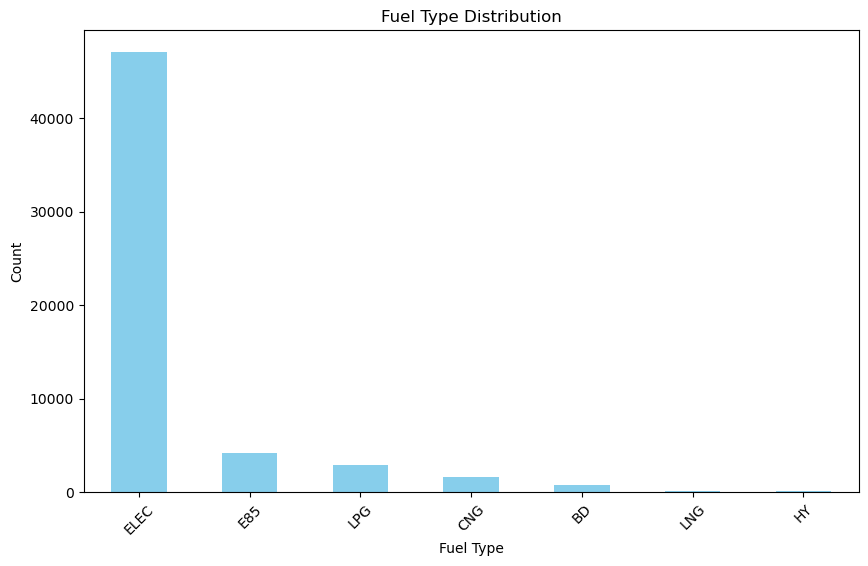

In [7]:
#Visualization with a bar chart to explore differnt fuel types
fuel_type_counts = final_fuel_df['Fuel Type'].value_counts()
plt.figure(figsize=(10, 6))
fuel_type_counts.plot(kind='bar', color='skyblue')
plt.title('Fuel Type Distribution')
plt.xlabel('Fuel Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


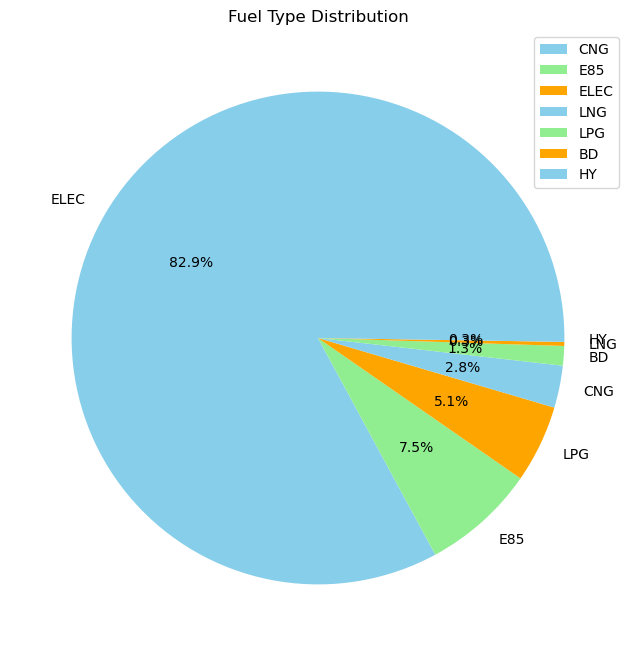

In [9]:
#Pie chart
fuel_types = final_fuel_df['Fuel Type'].unique()

# Pie chart
plt.figure(figsize=(8, 8))
fuel_type_counts.plot(kind='pie', autopct='%1.1f%%', colors=['skyblue', 'lightgreen', 'orange'])
plt.title('Fuel Type Distribution')

# Create a custom legend
plt.legend(labels=fuel_types)
plt.ylabel('')
plt.show()


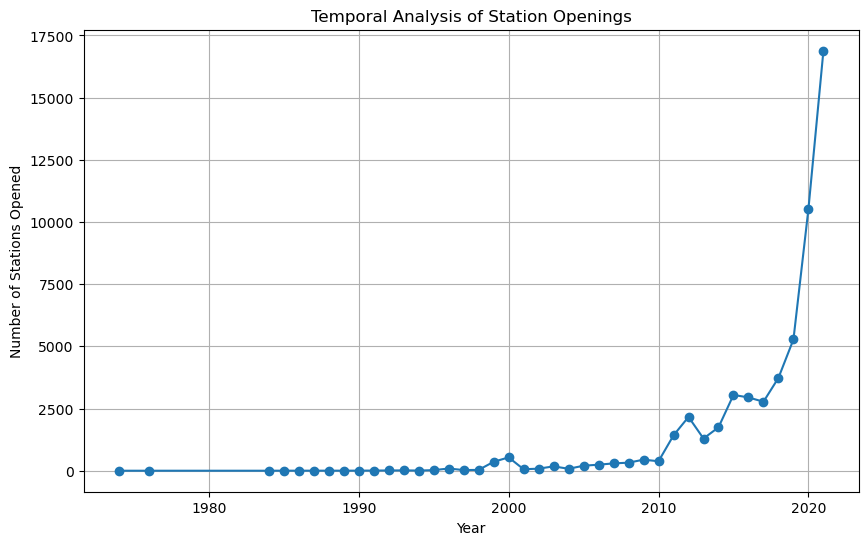

In [10]:
#temporal analysis of stations created throughout by Year:

final_fuel_df['Created_Date'] = pd.to_datetime(final_fuel_df['Created_Date'])

# Extract year from 'Created_Date'
final_fuel_df['Year'] = final_fuel_df['Created_Date'].dt.year

# Grouping the data by year and counting the number of stations opened each year
station_openings = final_fuel_df.groupby('Year').size()

# Plotting a line plot
plt.figure(figsize=(10, 6))
plt.plot(station_openings.index, station_openings.values, marker='o', linestyle='-')
plt.title('Temporal Analysis of Station Openings')
plt.xlabel('Year')
plt.ylabel('Number of Stations Opened')
plt.grid(True)
plt.show()


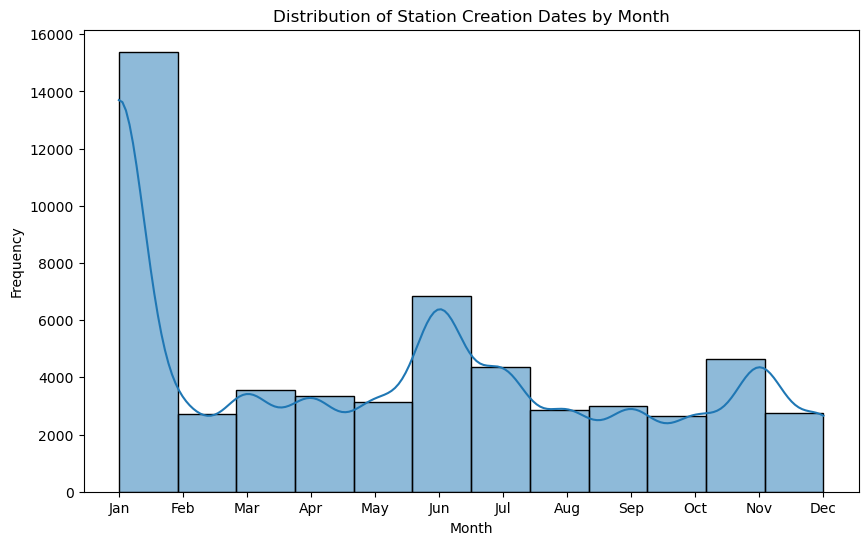

In [ ]:
# Extract month from 'Created_Date' column
final_fuel_df['Month'] = final_fuel_df['Created_Date'].dt.month

# Distribution of station creation dates by month
plt.figure(figsize=(10, 6))
sns.histplot(data=final_fuel_df, x='Month', bins=12, kde=True)
plt.xlabel('Month')
plt.ylabel('Frequency')
plt.title('Distribution of Station Creation Dates by Month')
plt.xticks(ticks=range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.show()


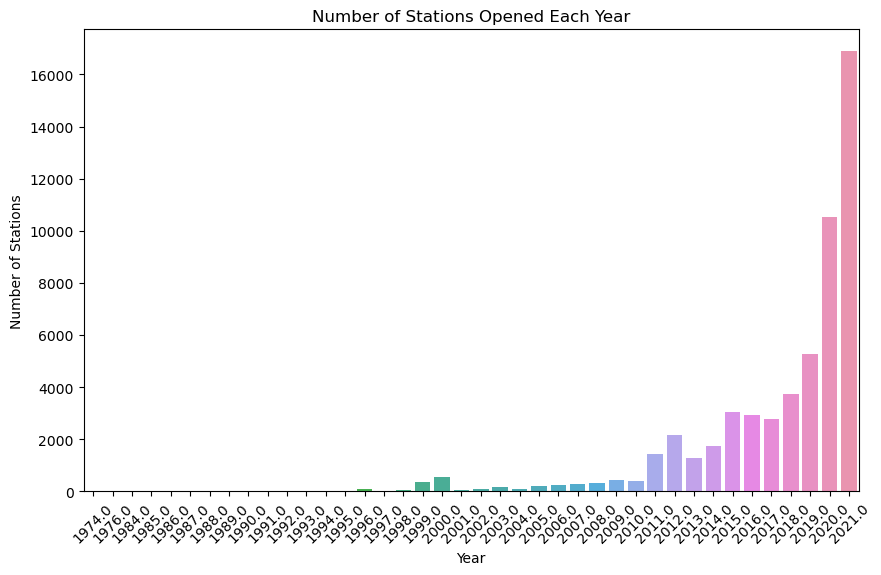

In [ ]:
# Distribution of station creation dates by year
plt.figure(figsize=(10, 6))
sns.countplot(data=final_fuel_df, x='Year')
plt.xlabel('Year')
plt.ylabel('Number of Stations')
plt.title('Number of Stations Opened Each Year')
plt.xticks(rotation=45)
plt.show()


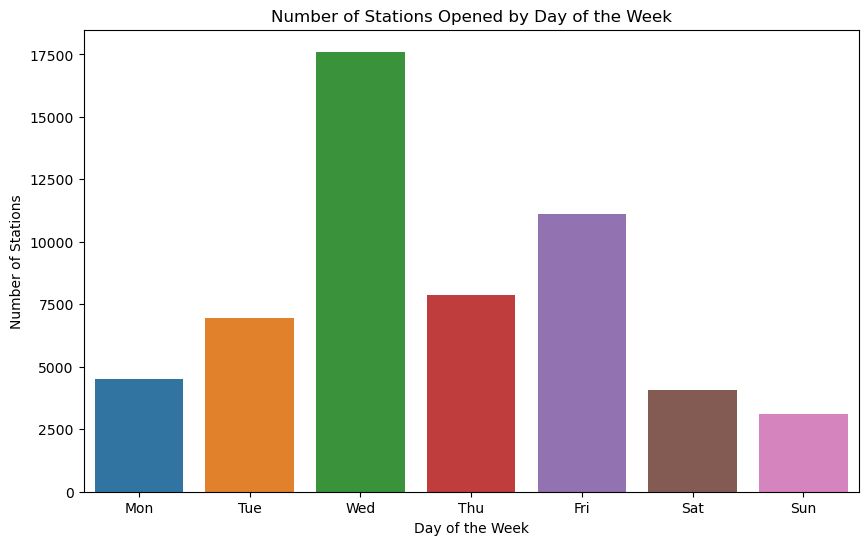

In [ ]:
# Extract day of the week from 'Created_Date' column
final_fuel_df['Day_of_Week'] = final_fuel_df['Created_Date'].dt.dayofweek

# Distribution of station creation dates by day of the week

plt.figure(figsize=(10, 6))
sns.countplot(data=final_fuel_df, x='Day_of_Week')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Stations')
plt.title('Number of Stations Opened by Day of the Week')
plt.xticks(ticks=range(7), labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.show()


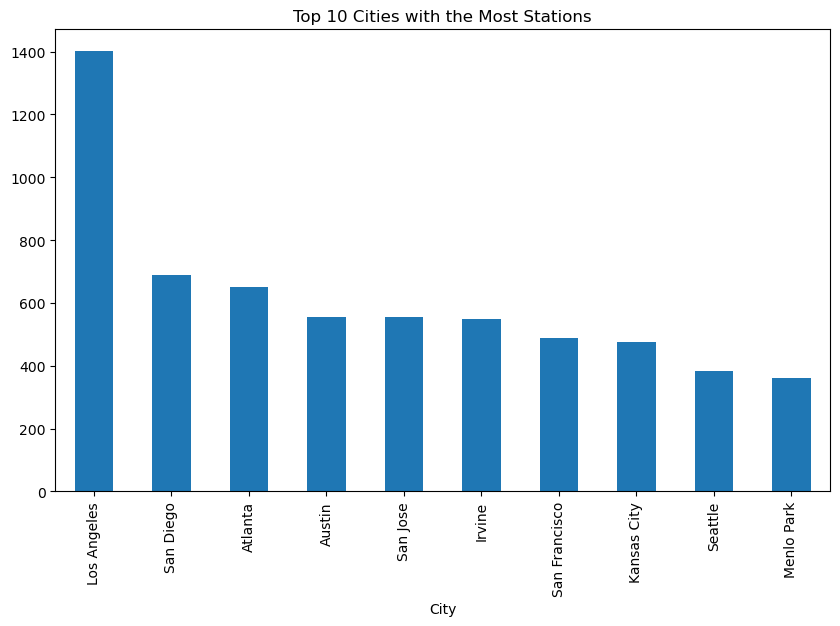

In [ ]:
#Performing an address analysis and analyze the distribution of stations based on their addresses

# Split the 'Address' column to extract street names, cities, and ZIP codes
address_parts = final_fuel_df['Address']

# Assign meaningful column names to the extracted parts
address_parts.columns = ['City', 'States']

# Concatenate the extracted parts with the original DataFrame
final_fuel_df_with_address = pd.concat([final_fuel_df, address_parts], axis=1)

# Now you can analyze the distribution of stations based on street names, cities, or ZIP codes
# For example, you can use value_counts() to get the frequency of each street, city, or ZIP code

city_distribution = final_fuel_df_with_address['City'].str.strip().value_counts()
state_distribution = final_fuel_df_with_address['States'].value_counts()

# You can also visualize the distributions using matplotlib or seaborn
# For example, to plot the top 10 cities with the most stations:
city_distribution.head(10).plot(kind='bar', figsize=(10, 6), title='Top 10 Cities with the Most Stations');



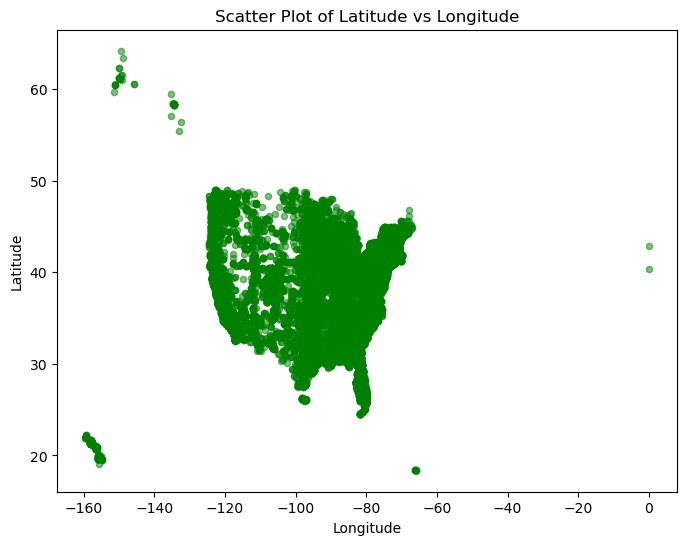

In [ ]:
#Correlation Analysis based on lattitude and longitude

plt.figure(figsize=(8, 6))
plt.scatter(final_fuel_df['lon'], final_fuel_df['lat'], s=20, alpha=0.5, color = "green")
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Scatter Plot of Latitude vs Longitude')
plt.show()

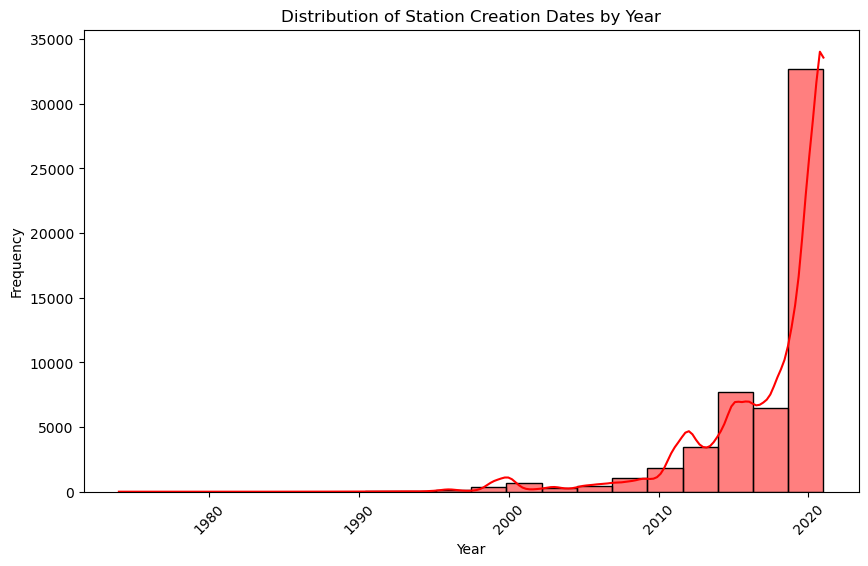

In [ ]:
# Distribution of station creation dates by year
plt.figure(figsize=(10, 6))
sns.histplot(data=final_fuel_df, x='Year', bins=20, kde=True, color = "red")
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.title('Distribution of Station Creation Dates by Year')
plt.xticks(rotation=45)
plt.show()

In [ ]:
#Interactive Heat map showing station density on states.

# Create a base map
#m = folium.Map(location=[37, -102], zoom_start=4)

#heat_data2 = [[row['lat'], row['lon']] for index, row in final_fuel_df.iterrows()]
#HeatMap(heat_data2).add_to(m)

#m


In [16]:
#heat Map of stations in the continental US
us_shapefile = 'States_shapefile.shp'
us_boundary2 = gpd.read_file(us_shapefile)
us_boundary2_json = us_boundary2.to_json()

# Create Folium Map
m2 = folium.Map(location=[37, -102], zoom_start=4)

# Create Heatmap layer
heat_map = HeatMap(final_fuel_df[['lat', 'lon']], min_opacity=0.5, radius=15, blur=10)

# Add Heatmap layer to map
m2.add_child(heat_map)

# Iterate over each row in final_fuel_df to add markers with popups
#for idx, row in final_fuel_df.iterrows():
    #popup_content = f"Station Name: {row['Station_Name']}<br>Fuel Type: {row['Fuel Type']}<br>State: {row['States']}"
    #folium.Marker([row['lat'], row['lon']], popup=popup_content).add_to(m2)

# Add US national boundaries layer with popups for fuel type
folium.GeoJson(us_boundary2_json, popup=final_fuel_df['Fuel Type']).add_to(m2)

# Add Layer Control
folium.LayerControl().add_to(m2)

# Save the map to an HTML file
m2.save('Heatmap_with_popups.html')

# Display the map
m2

In [14]:
small_fuel_df = final_fuel_df.head(1000)
small_fuel_df.head()

,City,lat,lon,Address,Station_Name,Fuel Type,States,Created_Date,geometry
0,Montgomery,32.367916,-86.267021,2951 Chestnut St,Spire - Montgomery Operations Center,CNG,AL,2010-12-01,POINT (-86.267021 32.367916)
1,Atlanta,33.745843,-84.398837,340 Whitehall St,PS Energy - Atlanta,CNG,GA,1994-07-15,POINT (-84.398837 33.745843)
2,Atlanta,33.821911,-84.367461,2424 Piedmont Rd NE,Metropolitan Atlanta Rapid Transit Authority,CNG,GA,1996-12-15,POINT (-84.367461 33.821911)
3,Atlanta,33.760256,-84.543822,270 Marvin Miller Dr,United Parcel Service,CNG,GA,1997-01-01,POINT (-84.543822 33.760256)
4,Houston,29.779918,-95.435385,7721A Washington St,Clean Energy - Texas Department of Transportation,CNG,TX,1996-12-15,POINT (-95.435385 29.779918)


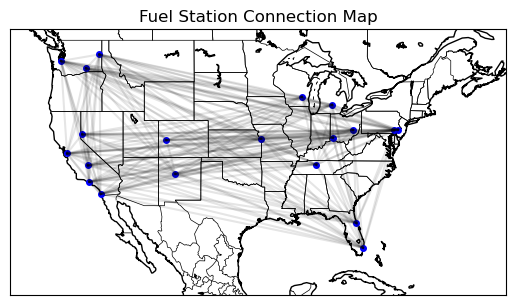

In [ ]:
# Create Basemap
m = Basemap(projection='merc', llcrnrlat=20, urcrnrlat=50, llcrnrlon=-130, urcrnrlon=-60, resolution='l')

# Draw coastlines, countries, and states
m.drawcoastlines()
m.drawcountries()
m.drawstates()

# Plot stations
for idx, row in small_fuel_df.iterrows():
    x, y = m(row['lon'], row['lat'])
    m.plot(x, y, 'bo', markersize=4)

# Plot connections between stations
for i in range(len(small_fuel_df)):
    for j in range(i + 1, len(small_fuel_df)):
        x1, y1 = m(small_fuel_df.iloc[i]['lon'], small_fuel_df.iloc[i]['lat'])
        x2, y2 = m(small_fuel_df.iloc[j]['lon'], small_fuel_df.iloc[j]['lat'])
        m.plot([x1, x2], [y1, y2], 'k-', alpha=0.1)  # Adjust alpha for transparency


plt.title('Fuel Station Connection Map')
plt.show()


/Users/brandoncooke/anaconda3/lib/python3.11/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


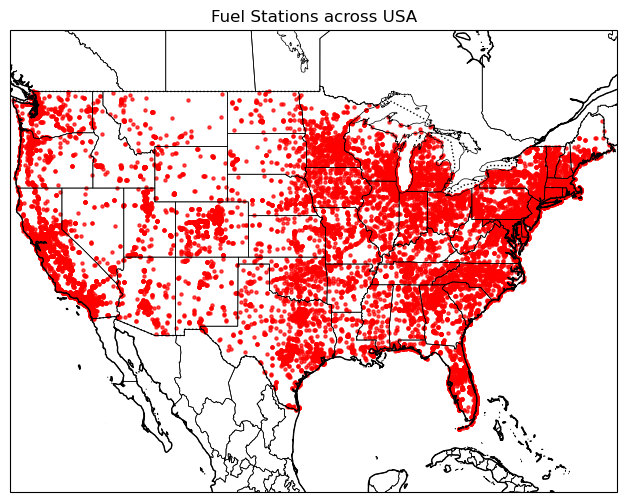

In [ ]:
us_shapefile = 'States_shapefile.shp'
us_boundary = gpd.read_file(us_shapefile)

# Create a GeoDataFrame from final_fuel_df
geometry = [Point(lon, lat) for lon, lat in zip(final_fuel_df['lon'], final_fuel_df['lat'])]
crs = {'init': 'epsg:4326'}
fuel_stations = gpd.GeoDataFrame(final_fuel_df, crs=crs, geometry=geometry)

# Plot the map using Cartopy
plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.STATES.with_scale('10m'), linewidth=0.5)
ax.set_extent([-125, -66.5, 20, 50])  # Adjust the extent as needed

# Plot fuel stations
fuel_stations.plot(ax=ax, color='red', markersize=5, alpha=0.7)

plt.title('Fuel Stations across USA')
plt.show()

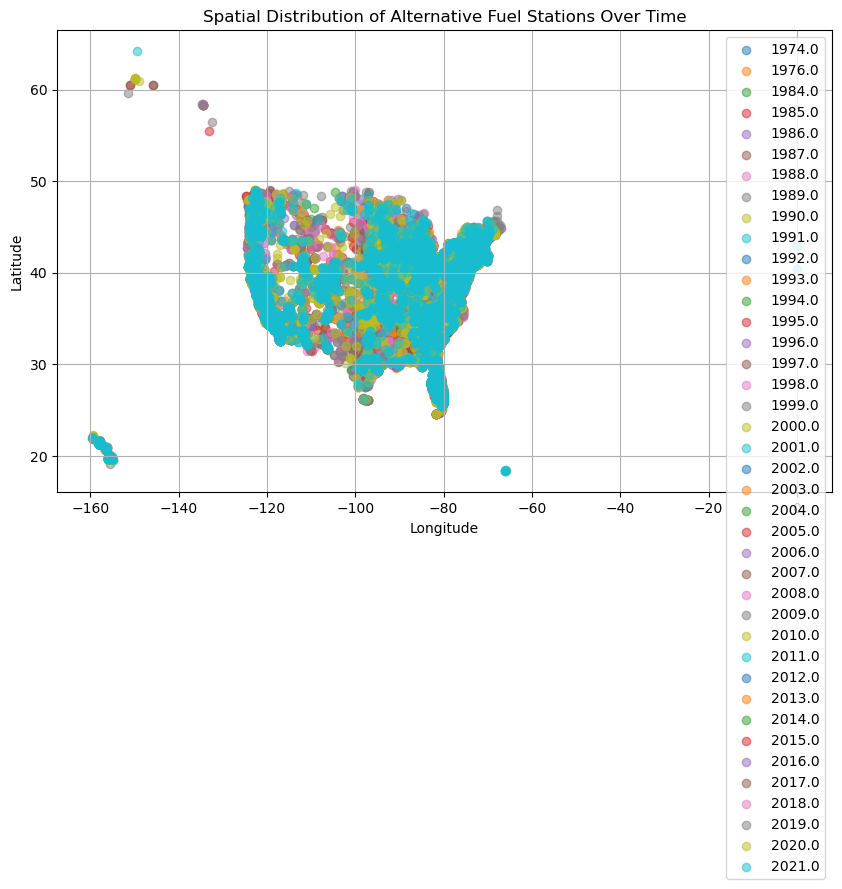

In [ ]:
#Spatial Distribution of Alternative Fuel Stations Over Time

plt.figure(figsize=(10, 6))
for year, group in final_fuel_df.groupby(final_fuel_df['Year']):
    plt.scatter(group['lon'], group['lat'], label=year, alpha=0.5)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Spatial Distribution of Alternative Fuel Stations Over Time')
plt.legend()
plt.grid(True)
plt.show()


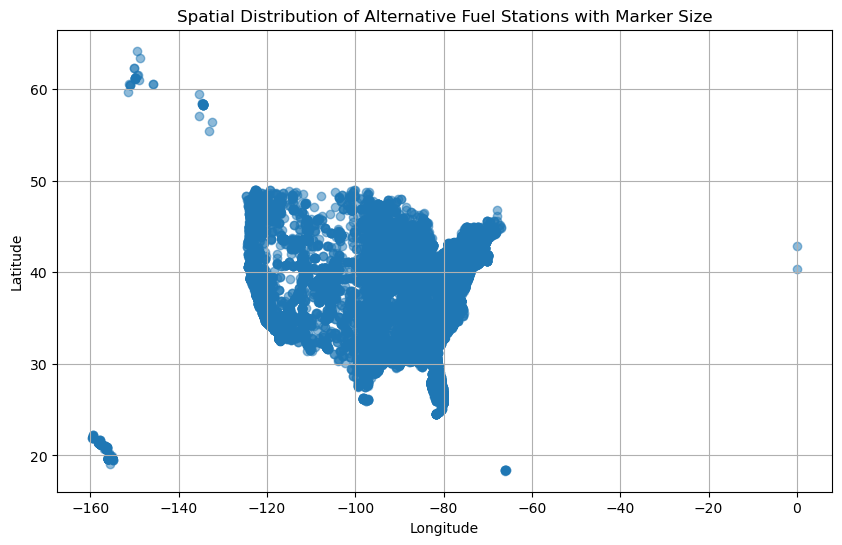

In [ ]:
#Latitude vs. Longitude with Marker Size:

plt.figure(figsize=(10, 6))
# Compute marker sizes based on the entire DataFrame
marker_sizes = final_fuel_df.groupby(['lon', 'lat']).size().values * 10
plt.scatter(final_fuel_df['lon'], final_fuel_df['lat'], alpha=0.5)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Spatial Distribution of Alternative Fuel Stations with Marker Size')
plt.grid(True)
plt.show()


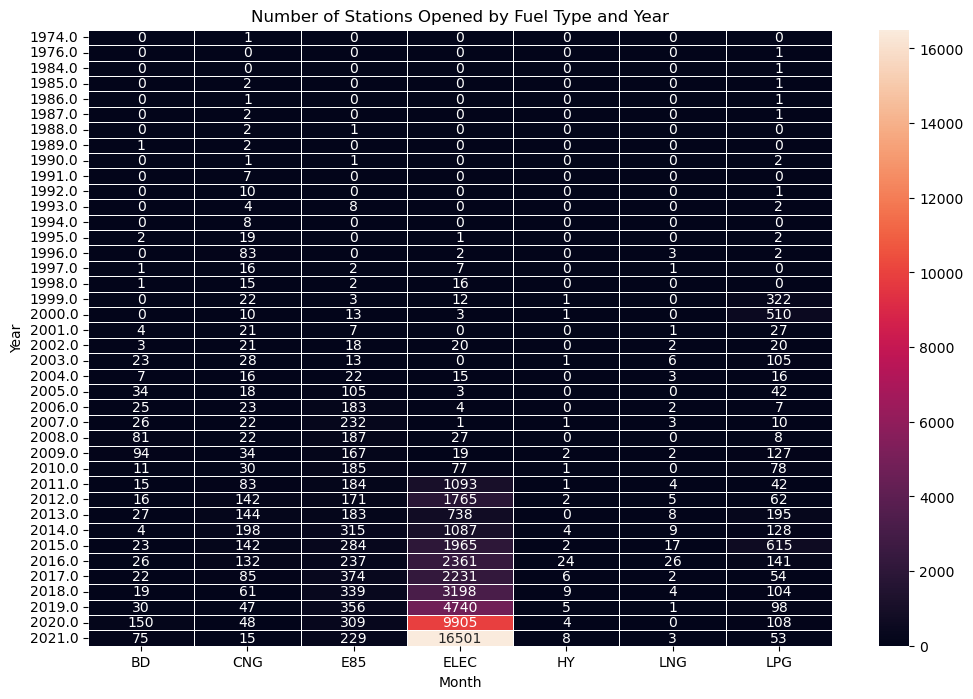

In [ ]:
# Aggregate data by month and year
# This heatmap describes the number of alternative fuel stations opened by month and year. 
# Each cell in the heatmap represents the count of stations opened in a specific month of a specific 
# year. The rows represent years, and the columns represent months. The color intensity or 
# annotation within each cell indicates the count of stations opened during that month and year. 
# This visualization helps in understanding the temporal distribution of station openings over the 
# years.

final_fuel_df['Year'] = final_fuel_df['Created_Date'].dt.year
final_fuel_df['Month'] = final_fuel_df['Created_Date'].dt.month

monthly_counts = final_fuel_df.groupby(['Year', 'Fuel Type']).size().unstack()

monthly_counts = monthly_counts.fillna(0).astype(int)

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(monthly_counts, annot=True, fmt='d', linewidths=.5)
plt.title('Number of Stations Opened by Fuel Type and Year')
plt.xlabel('Month')
plt.ylabel('Year')
plt.show()

In [ ]:
# Create a dictionary with lat and lon data
multi_iter2 = {
    "x": small_fuel_df['lon'].values,
    "y": small_fuel_df['lat'].values,
}

# Create a scatter plot using Vincent
scatter = vincent.Scatter(multi_iter2, iter_idx="x", height=100, width=200)

# Convert the scatter plot to JSON
data = json.loads(scatter.to_json())

# Create a Folium map
m3 = folium.Map([0, 0], zoom_start=1)

# Iterate through each station and add a marker with a popup
for idx, row in small_fuel_df.iterrows():
    marker = folium.Marker([row['lat'], row['lon']])
    popup = folium.Popup(row['Station_Name'])
    popup.add_to(marker)
    marker.add_to(m3)

# Display the map
#m3

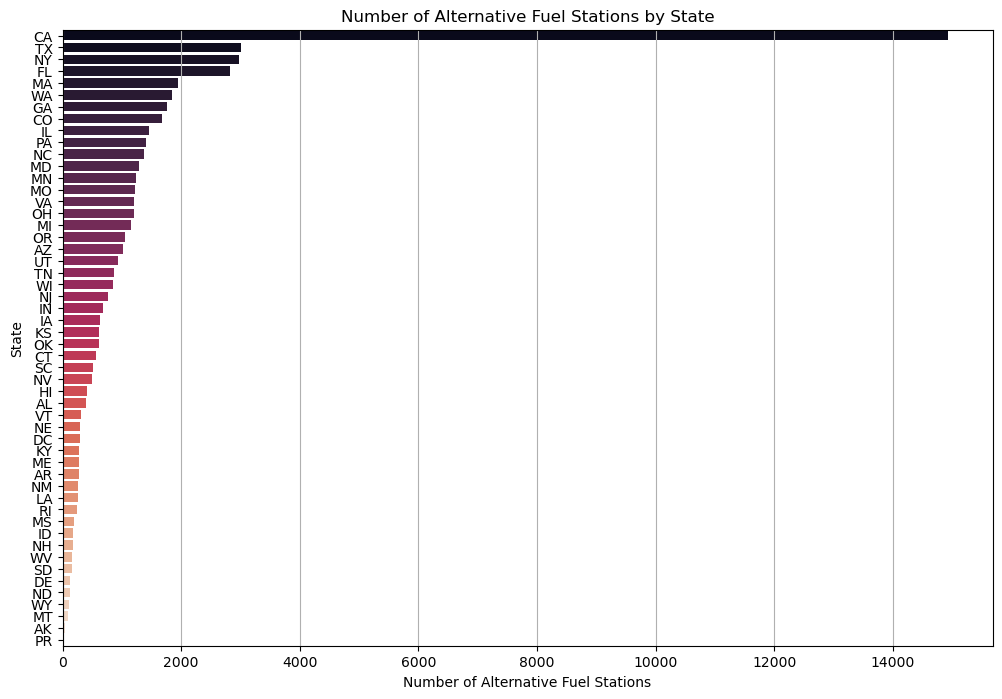

In [ ]:
#this code snippet provides a clear and visually appealing way to analyze the distribution 
# of alternative fuel stations across different states. The resulting bar plot helps in 
# identifying states with the highest number of alternative fuel stations.

# Filter rows with alternative fuel types (e.g., CNG)
alt_fuel_df = final_fuel_df[final_fuel_df['Fuel Type'] != 'Gasoline']

# Count the number of alternative fuel stations for each state
alt_station_counts = alt_fuel_df['States'].value_counts().reset_index()
alt_station_counts.columns = ['State', 'Number of Alternative Fuel Stations']

# Sort the dataframe by the number of stations
alt_station_counts = alt_station_counts.sort_values(by='Number of Alternative Fuel Stations', ascending=False)

# Plotting the counts
plt.figure(figsize=(12, 8))
sns.barplot(x='Number of Alternative Fuel Stations', y='State', data=alt_station_counts, palette='rocket')
plt.xlabel('Number of Alternative Fuel Stations')
plt.ylabel('State')
plt.title('Number of Alternative Fuel Stations by State')
plt.grid(axis='x')  # Add grid lines for better readability
plt.show()


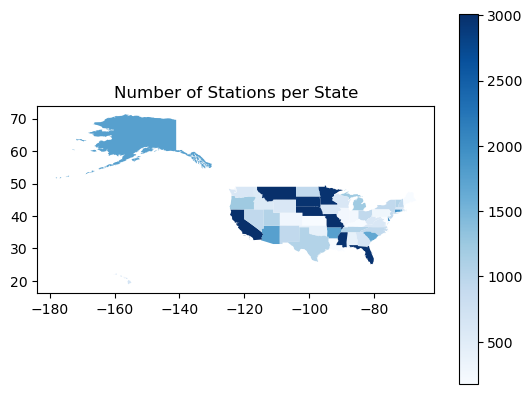

In [ ]:

states_gdf = gpd.read_file('States_shapefile.shp')


states_gdf['States'] = final_fuel_df['States']


state_counts = final_fuel_df['States'].value_counts().reset_index()
state_counts.columns = ['States', 'Station_Count']


states_gdf = states_gdf.merge(state_counts, on='States', how='left')

# Plot choropleth map
states_gdf.plot(column='Station_Count', cmap='Blues', legend=True)
plt.title('Number of Stations per State')
plt.show()


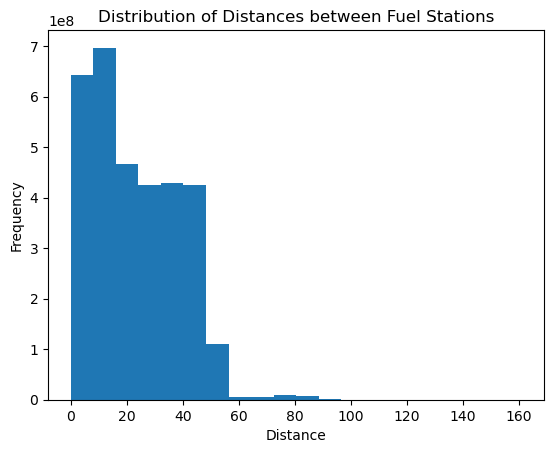

In [ ]:
distances = distance_matrix(final_fuel_df[['lon', 'lat']], final_fuel_df[['lon', 'lat']])

# Create a DataFrame to store the distances
distance_df = pd.DataFrame(distances, index=final_fuel_df.index, columns=final_fuel_df.index)

# Plot a histogram of distances between stations
import matplotlib.pyplot as plt

plt.hist(distance_df.values.flatten(), bins=20)
plt.xlabel('Distance')
plt.ylabel('Frequency')
plt.title('Distribution of Distances between Fuel Stations')
plt.show()

<Figure size 1000x600 with 0 Axes>

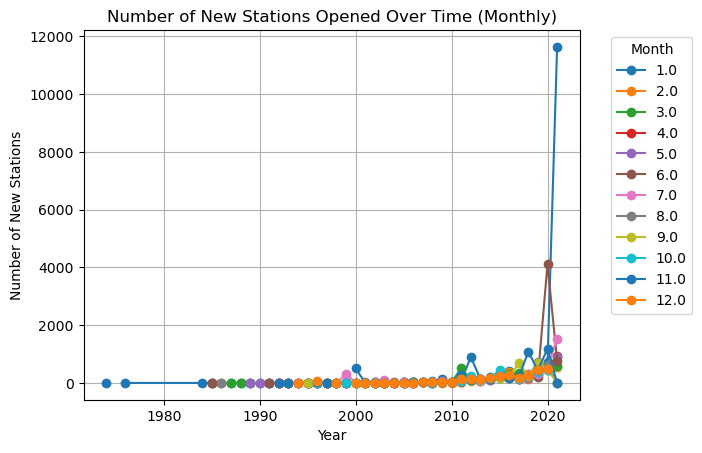

In [ ]:
#trend of new stations being opened over time. The first plot shows the count of new 
# stations opened each year, while the second plot (optional) shows the count of new 
# stations opened each month, stacked by year for comparison. Adjust the plot settings 
# according to your preference for better visualization.

# Convert 'Created_Date' to datetime
final_fuel_df['Created_Date'] = pd.to_datetime(final_fuel_df['Created_Date'])

# Extract year and month from 'Created_Date'
final_fuel_df['Year'] = final_fuel_df['Created_Date'].dt.year
final_fuel_df['Month'] = final_fuel_df['Created_Date'].dt.month  # Optional, if you want to analyze by month

# Count the number of stations opened each year (and optionally each month)
station_counts_by_year = final_fuel_df['Year'].value_counts().sort_index()
station_counts_by_month = final_fuel_df.groupby(['Year', 'Month']).size()  # Optional, if you want to analyze by month


# Plotting the counts over time (by month, optional)
plt.figure(figsize=(10, 6))
station_counts_by_month.unstack().plot(kind='line', marker='o')
plt.title('Number of New Stations Opened Over Time (Monthly)')
plt.xlabel('Year')
plt.ylabel('Number of New Stations')
plt.legend(title='Month', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show();

/Users/brandoncooke/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


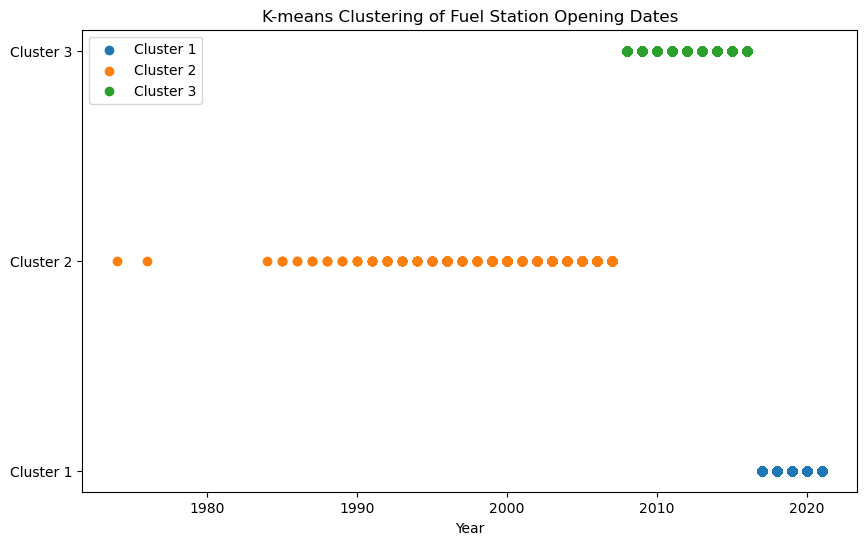

In [ ]:
# This code performs K-means clustering on the opening dates of fuel stations and 
# provides a visual representation of the clusters, helping to identify any temporal 
# patterns or trends in the data. Adjustments to the number of clusters or other 
# parameters can be made based on the desired analysis goals.

import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

final_fuel_df.dropna(inplace=True)

# Extract opening dates from the DataFrame
opening_dates = final_fuel_df['Created_Date'].dt.year.values.reshape(-1, 1)  # Assuming you want to cluster by year

# Choose the number of clusters (you may need to experiment with different values)
num_clusters = 3

# Apply K-means clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
clusters = kmeans.fit_predict(opening_dates)

# Visualize the clusters
plt.figure(figsize=(10, 6))
for cluster_id in range(num_clusters):
    plt.scatter(opening_dates[clusters == cluster_id], [cluster_id] * sum(clusters == cluster_id), label=f'Cluster {cluster_id+1}')

plt.xlabel('Year')
plt.yticks(range(num_clusters), [f'Cluster {i+1}' for i in range(num_clusters)])
plt.title('K-means Clustering of Fuel Station Opening Dates')
plt.legend()
plt.show()

Average Distance Between Stations: 1680.9731273774123 kilometers


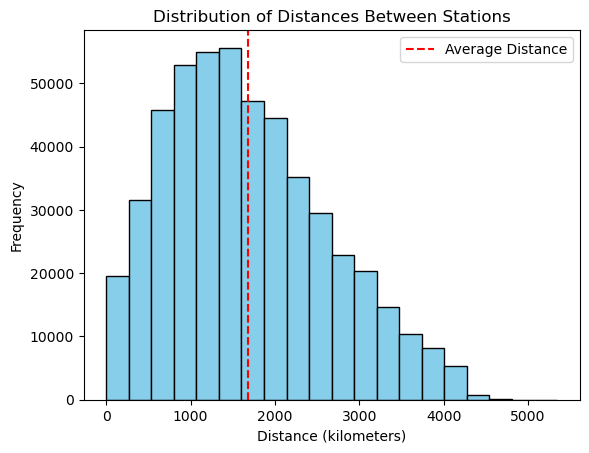

In [12]:
distances = []
for i in range(len(small_fuel_df)):
    for j in range(i + 1, len(small_fuel_df)):
        coords_i = (small_fuel_df.at[i, 'lat'], small_fuel_df.at[i, 'lon'])
        coords_j = (small_fuel_df.at[j, 'lat'], small_fuel_df.at[j, 'lon'])
        distances.append(geodesic(coords_i, coords_j).kilometers)

# Calculate the average distance
average_distance = np.mean(distances)

print("Average Distance Between Stations:", average_distance, "kilometers")

plt.hist(distances, bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Distance (kilometers)')
plt.ylabel('Frequency')
plt.title('Distribution of Distances Between Stations')
plt.axvline(x=average_distance, color='red', linestyle='--', label='Average Distance')
plt.legend()
plt.show()

Average Distance Between Stations: 1680.9731273774123 kilometers


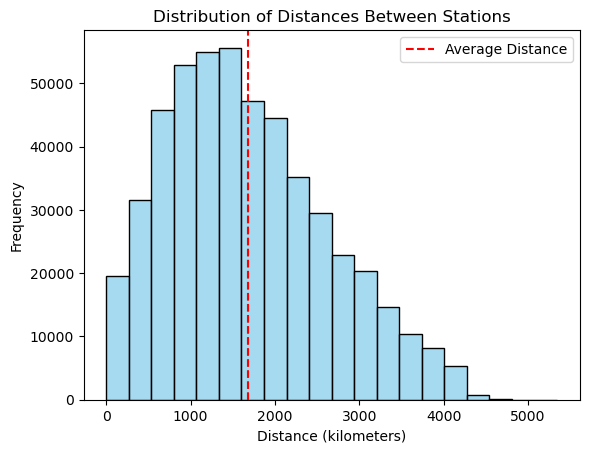

In [13]:
average_distance = np.mean(distances)

print("Average Distance Between Stations:", average_distance, "kilometers")

# Plot histogram of distances using Seaborn
sns.histplot(distances, bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Distance (kilometers)')
plt.ylabel('Frequency')
plt.title('Distribution of Distances Between Stations')
plt.axvline(x=average_distance, color='red', linestyle='--', label='Average Distance')
plt.legend()
plt.show()